LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation
- Link: [Paper](https://arxiv.org/pdf/2002.02126.pdf)

In [1]:
import sys
sys.path.append('../../')
import random
import time
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch_sparse import SparseTensor

from helper.lite_gcn_utils import *
from models.lite_gcn import LightGCN

In [2]:
BASE_PATH = Path('../../raw_data/movie-lens/ml-latest-small')
RATING_THRESHOLD = 4.

In [3]:
df_movies = pd.read_csv(BASE_PATH/'movies.csv', index_col='movieId')
df_links = pd.read_csv(BASE_PATH/'links.csv')
df_tags = pd.read_csv(BASE_PATH/'tags.csv')
df_ratings = pd.read_csv(BASE_PATH/'ratings.csv', index_col='userId')

In [4]:
user_map, new_user_map = map_to_index(df_ratings)
item_map, new_item_map = map_to_index(df_movies)
edge_index = get_edges(
    df=df_ratings,
    edge_col='rating',
    item_col='movieId',
    user_map=user_map,
    item_map=item_map,
    thresh=RATING_THRESHOLD,
)

num_users, num_movies = len(user_map), len(item_map)
num_interactions = edge_index.shape[1]

all_indices = [i for i in range(num_interactions)]
train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1,
)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1,
)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

train_sparse_edge_index = SparseTensor(
    row=train_edge_index[0], col=train_edge_index[1], 
    sparse_sizes=(
        num_users + num_movies, num_users + num_movies,
    ),
)
val_sparse_edge_index = SparseTensor(
    row=val_edge_index[0], col=val_edge_index[1],
    sparse_sizes=(
        num_users + num_movies, num_users + num_movies,
    ),
)
test_sparse_edge_index = SparseTensor(
    row=test_edge_index[0], col=test_edge_index[1],
    sparse_sizes=(
        num_users + num_movies, num_users + num_movies,
    ),
)

In [5]:
EMBEDDING_DIM = 64
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

model = LightGCN(
    num_users, 
    num_movies,
    emb_dim=EMBEDDING_DIM,
    num_layers=5,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu


In [6]:
train_losses = []
val_losses = []

for i in range(ITERATIONS):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index,
    )
    user_indices, pos_item_indices, neg_item_indices = sample(
        BATCH_SIZE, train_edge_index,
    )
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(
        users_emb_final, users_emb_0,
        pos_items_emb_final, pos_items_emb_0,
        neg_items_emb_final, neg_items_emb_0,
        LAMBDA,
    )

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if i % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision = evaluation(
            model, val_edge_index, 
            val_sparse_edge_index, [train_edge_index],
            K, LAMBDA,
        )
        print(f"[{i}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if i % ITERS_PER_LR_DECAY == 0 and i != 0:
        scheduler.step()

[0/10000] train_loss: -0.6952, val_loss: -0.70248, val_recall@20: 0.00089, val_precision@20: 0.00081
[200/10000] train_loss: -0.70158, val_loss: -0.7133, val_recall@20: 0.01441, val_precision@20: 0.00443
[400/10000] train_loss: -0.77349, val_loss: -0.80246, val_recall@20: 0.07402, val_precision@20: 0.02315
[600/10000] train_loss: -1.05162, val_loss: -1.13566, val_recall@20: 0.0861, val_precision@20: 0.02712
[800/10000] train_loss: -1.64023, val_loss: -1.80827, val_recall@20: 0.08965, val_precision@20: 0.02758
[1000/10000] train_loss: -2.47841, val_loss: -2.76681, val_recall@20: 0.08775, val_precision@20: 0.02767
[1200/10000] train_loss: -3.67136, val_loss: -3.89343, val_recall@20: 0.08517, val_precision@20: 0.02703
[1400/10000] train_loss: -4.79798, val_loss: -5.1142, val_recall@20: 0.08471, val_precision@20: 0.02694
[1600/10000] train_loss: -5.92633, val_loss: -6.36168, val_recall@20: 0.08408, val_precision@20: 0.02703
[1800/10000] train_loss: -6.74987, val_loss: -7.63304, val_recall@

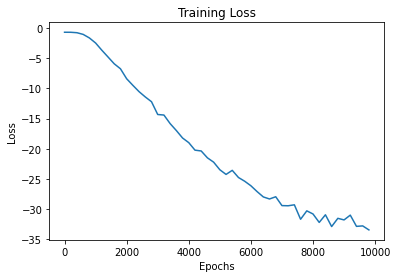

In [7]:
import matplotlib.pyplot as plt
# print(train_loss)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(np.arange(0,ITERATIONS,ITERS_PER_EVAL),train_losses)

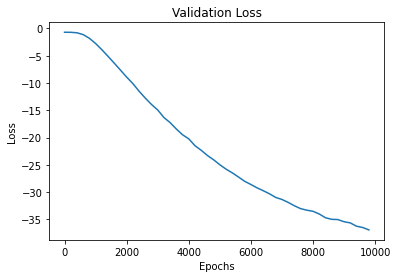

In [8]:
import matplotlib.pyplot as plt
# print(train_loss)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(np.arange(0,ITERATIONS,ITERS_PER_EVAL),val_losses)

In [9]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}")

[test_loss: -34.46054, test_recall@20: 0.0736, test_precision@20: 0.02708


In [10]:
model.eval()
movieid_title = pd.Series(df_movies.title.values).to_dict()
movieid_genres = pd.Series(df_movies.genres.values).to_dict()

user_pos_items = get_user_positive_items(edge_index)

def get_recommendations(df_ratings, df_movies, user_id, n, new_item_map):
    new_user_id = user_map[user_id]
    user_embed = model.user_emb.weight[new_user_id]
    scores = model.item_emb.weight @ user_embed
    
    df_ratings = df_ratings[(df_ratings.movieId == user_id) & (df_ratings.rating >= RATING_THRESHOLD)]
    top_rated = pd.merge(
        df_movies, df_ratings, 
        left_on=df_movies.index, right_on=df_ratings.index,
    ).sort_values(by='rating', ascending=False)[['title', 'genres', 'rating']]
    
    values, indices = torch.topk(scores, k=len(user_pos_items[new_user_id]))
    recommended = []
    m = min(n, indices.shape[0])
    
    for i in range(m):
        if indices[i] not in user_pos_items[new_user_id]:
            recommended.append(new_item_map[indices[i].cpu().item()])
        
    rec_movies = df_movies.iloc[recommended, :][['title', 'genres']]
    
    return top_rated.sample(n), rec_movies.head(n), rec_movies[::-1].head(n)
   

In [11]:
USER_ID = 2
NUM_RECS = 5

rated, rec, least_rec = get_recommendations(df_ratings, df_movies, USER_ID, NUM_RECS, new_item_map)
rated

,title,genres,rating
21,"Crow, The (1994)",Action|Crime|Fantasy|Thriller,4.0
34,Shadowlands (1993),Drama|Romance,4.5
6,Unforgettable (1996),Mystery|Sci-Fi|Thriller,4.0
14,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,4.0
13,Total Eclipse (1995),Drama|Romance,4.0


In [12]:
rec

,title,genres
movieId,,
360,I Love Trouble (1994),Action|Comedy
412,"Age of Innocence, The (1993)",Drama
338,Virtuosity (1995),Action|Sci-Fi|Thriller
735,Cemetery Man (Dellamorte Dellamore) (1994),Horror
300,Quiz Show (1994),Drama
